In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D as Convolution1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
# **Setup thiết bị GPU hoặc CPU**
device_name = "GPU:0" if tf.config.list_physical_devices('GPU') else "CPU:0"
print(f"Using device: {device_name}")

Using device: CPU:0


In [73]:
def analyze_dataset(data, title):
    """Phân tích và hiển thị thông tin về dataset"""
    # Tạo figure với kích thước lớn hơn và margins rõ ràng
    plt.figure(figsize=(20, 15))
    
    # Tạo grid với khoảng cách giữa các subplots
    gs = plt.GridSpec(2, 2, width_ratios=[1.3, 1], height_ratios=[1, 1], hspace=0.4, wspace=0.3)
    
    # 1. Phân phối các lớp với legend bên ngoài
    plt.subplot(gs[0, 0])
    class_dist = data['label'].value_counts()
    wedges, texts, autotexts = plt.pie(class_dist, labels=["" for _ in class_dist], autopct='%1.1f%%')
    # Tạo legend bên phải biểu đồ với phần trăm
    labels = [f'{label} ({pct.get_text()})' for label, pct in zip(class_dist.index, autotexts)]
    plt.legend(wedges, labels,
              title="Attack Types",
              loc="center left",
              bbox_to_anchor=(1, 0.5))
    plt.title(f'Class Distribution in {title}\n', pad=20)
    
    # 2. Top protocol types
    plt.subplot(gs[0, 1])
    protocol_dist = data['protocol_type'].value_counts().head(10)
    ax = sns.barplot(x=protocol_dist.values, y=protocol_dist.index)
    plt.title(f'Top Protocol Types in {title}\n', pad=20)
    plt.xlabel('Count', labelpad=10)
    # Thêm giá trị vào cuối mỗi thanh
    for i, v in enumerate(protocol_dist.values):
        ax.text(v, i, f' {v}', va='center')
    
    # 3. Top 10 services
    plt.subplot(gs[1, 0])
    service_dist = data['service'].value_counts().head(10)
    ax = sns.barplot(x=service_dist.values, y=service_dist.index)
    plt.title(f'Top 10 Services in {title}\n', pad=20)
    plt.xlabel('Count', labelpad=10)
    # Thêm giá trị vào cuối mỗi thanh
    for i, v in enumerate(service_dist.values):
        ax.text(v, i, f' {v}', va='center')
    
    # 4. Distribution of flags
    plt.subplot(gs[1, 1])
    flag_dist = data['flag'].value_counts()
    ax = sns.barplot(x=flag_dist.values, y=flag_dist.index)
    plt.title(f'Flag Distribution in {title}\n', pad=20)
    plt.xlabel('Count', labelpad=10)
    # Thêm giá trị vào cuối mỗi thanh
    for i, v in enumerate(flag_dist.values):
        ax.text(v, i, f' {v}', va='center')
    
    plt.suptitle(f'Analysis of {title}', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()
    
    # Hiển thị thống kê cơ bản cho các trường số
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    plt.figure(figsize=(20, 6))
    for i, col in enumerate(numeric_cols[:5], 1):
        plt.subplot(1, 5, i)
        sns.boxplot(y=data[col])
        plt.title(f'{col} Distribution\n', pad=20)
    plt.tight_layout(pad=3.0)
    plt.show()
    
    # Correlation matrix cho các trường số
    plt.figure(figsize=(15, 10))
    correlation = data[numeric_cols].corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))  # Tạo mask cho tam giác trên
    sns.heatmap(correlation, mask=mask, annot=False, cmap='coolwarm', center=0,
                square=True, linewidths=.5)
    plt.title(f'Correlation Matrix for Numeric Features in {title}\n', pad=20)
    plt.tight_layout()
    plt.show()

In [74]:
# **Hàm tiền xử lý cho phát hiện bất thường (Anomaly Detection)**
def preprocessing_anomaly(data):
    # Create a copy of the data
    df = data.copy()
    
    # Mã hóa các cột phân loại
    categorical_cols = ['protocol_type', 'service', 'flag']
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    
    # Tạo nhãn one-hot
    labels = df['label'].apply(lambda x: 0 if x == 'normal' else 1).values
    y = np.zeros((len(labels), 2))
    for i, label in enumerate(labels):
        y[i][label] = 1
    
    # Xóa cột label và difficulty trước khi scale
    if 'label' in df.columns:
        df = df.drop('label', axis=1)
    if 'difficulty' in df.columns:
        df = df.drop('difficulty', axis=1)
    
    # Chuyển đổi tất cả dữ liệu thành số
    df = df.apply(pd.to_numeric, errors='coerce')
    
    # Chuẩn hóa dữ liệu về [0, 1]
    x = MinMaxScaler(feature_range=(0, 1)).fit_transform(df)
    
    return x, y

In [75]:
# **Tải dữ liệu huấn luyện và kiểm tra**
train_file = 'NSL_KDD_Train.csv'
test_file = 'NSL_KDD_Test.csv'
featureV = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", 
            "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised", 
            "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells", 
            "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", 
            "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", 
            "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", 
            "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
            "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", 
            "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", 
            "difficulty"]

train_data = pd.read_csv(train_file, names=featureV)
test_data = pd.read_csv(test_file, names=featureV)

Analyzing Training Data:


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12004\3136475511.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


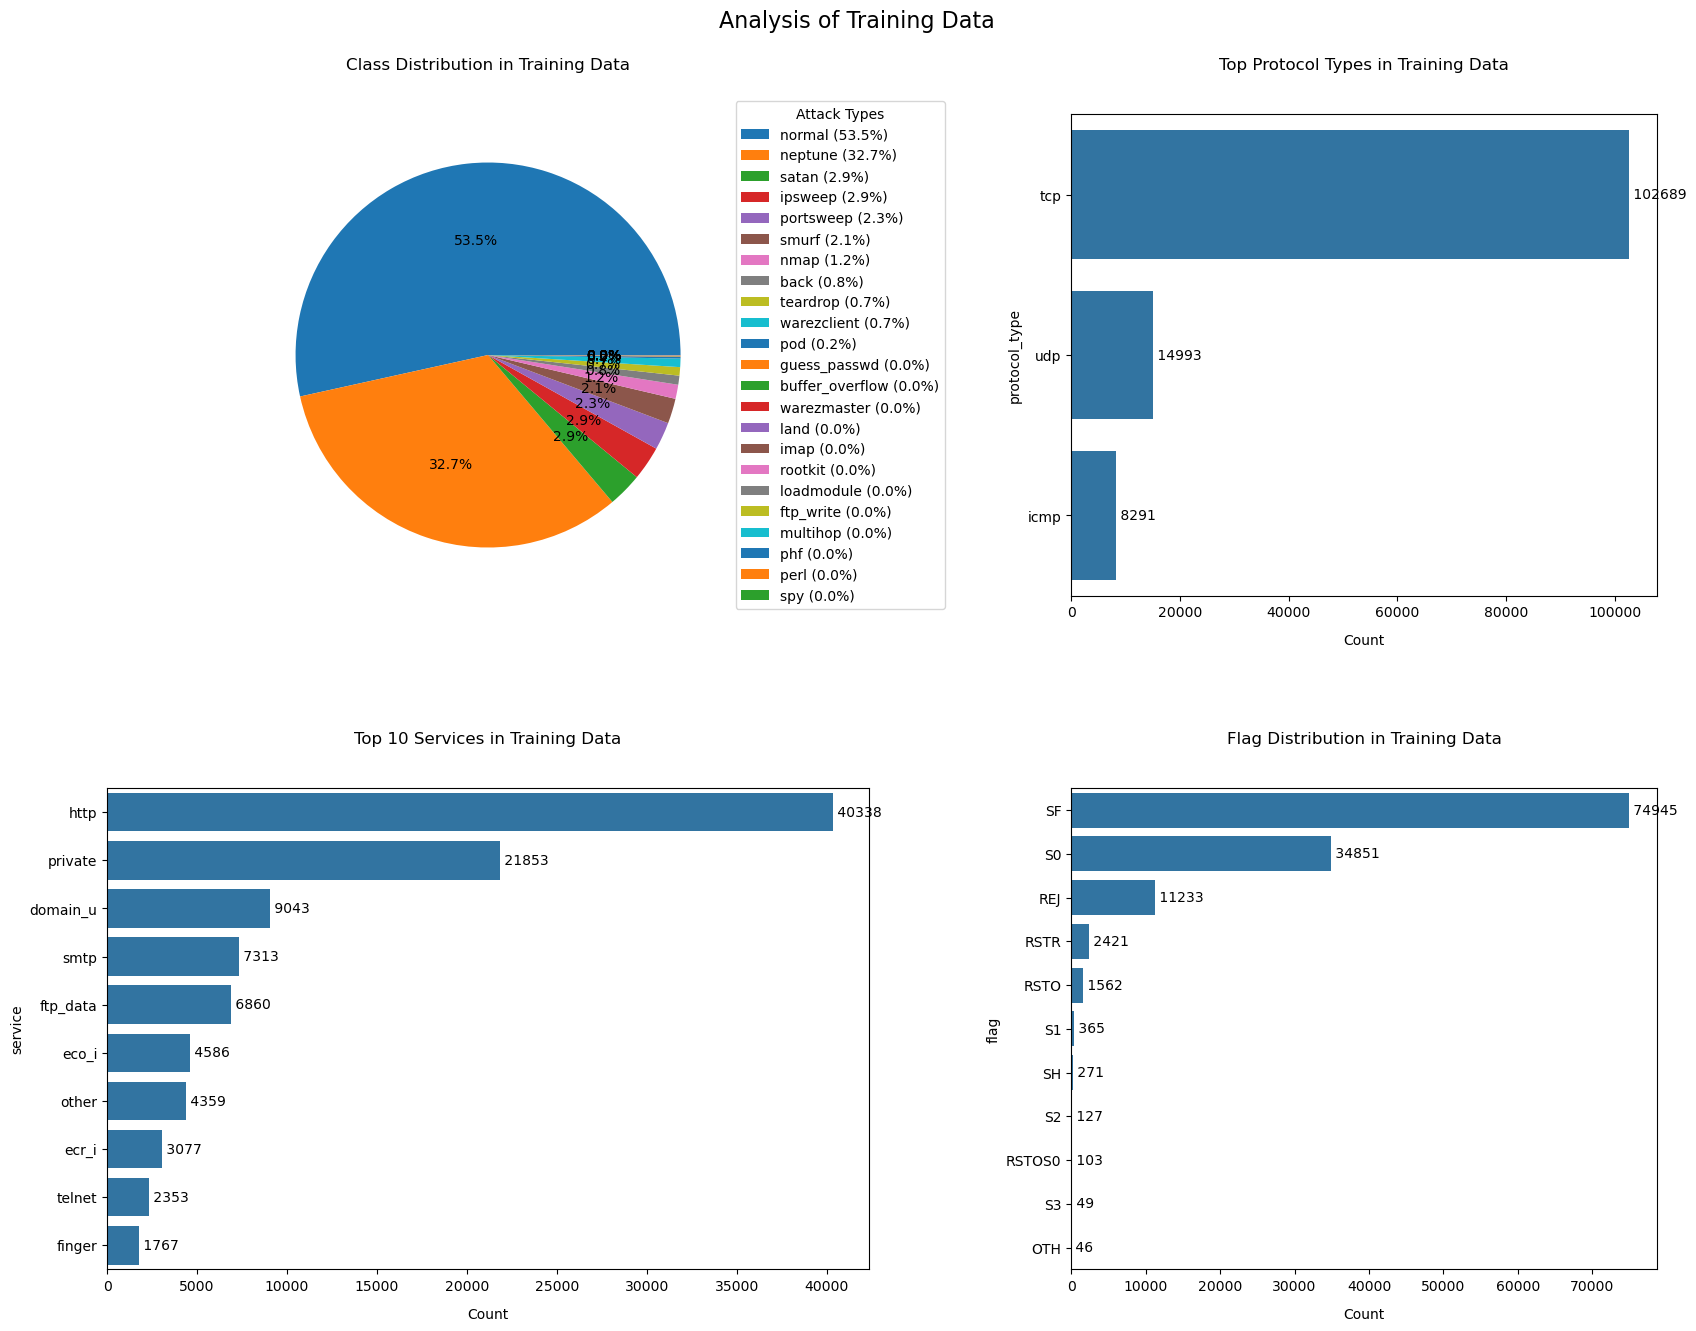

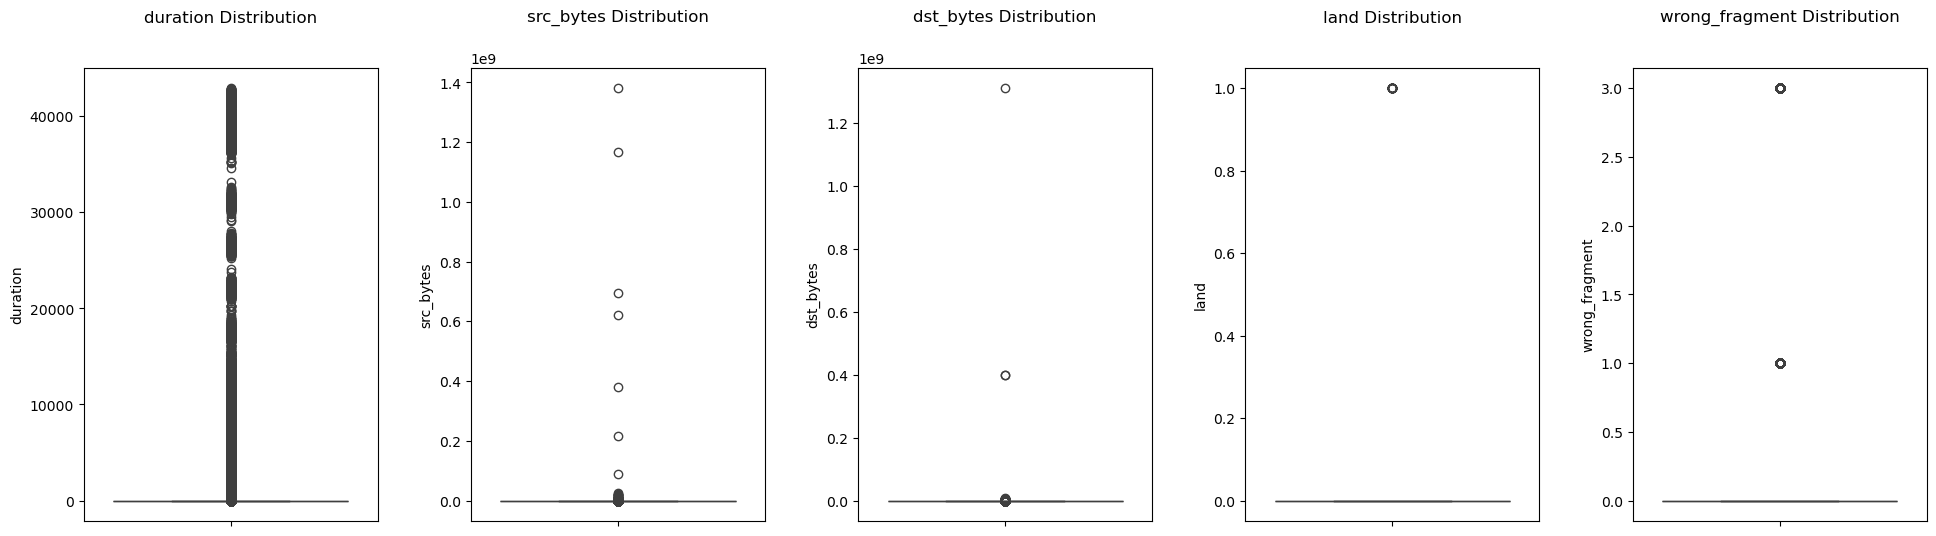

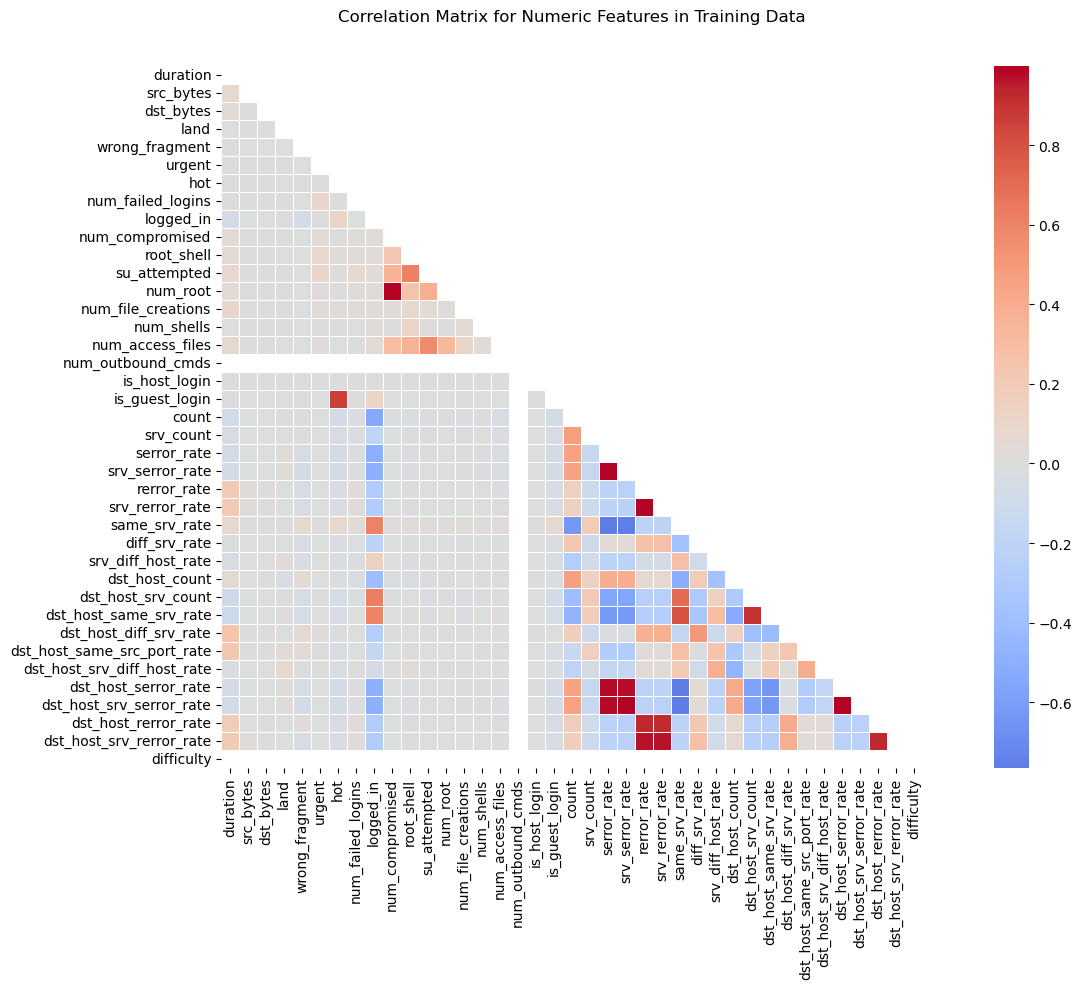


Analyzing Testing Data:


C:\Users\Administrator\AppData\Local\Temp\ipykernel_12004\3136475511.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


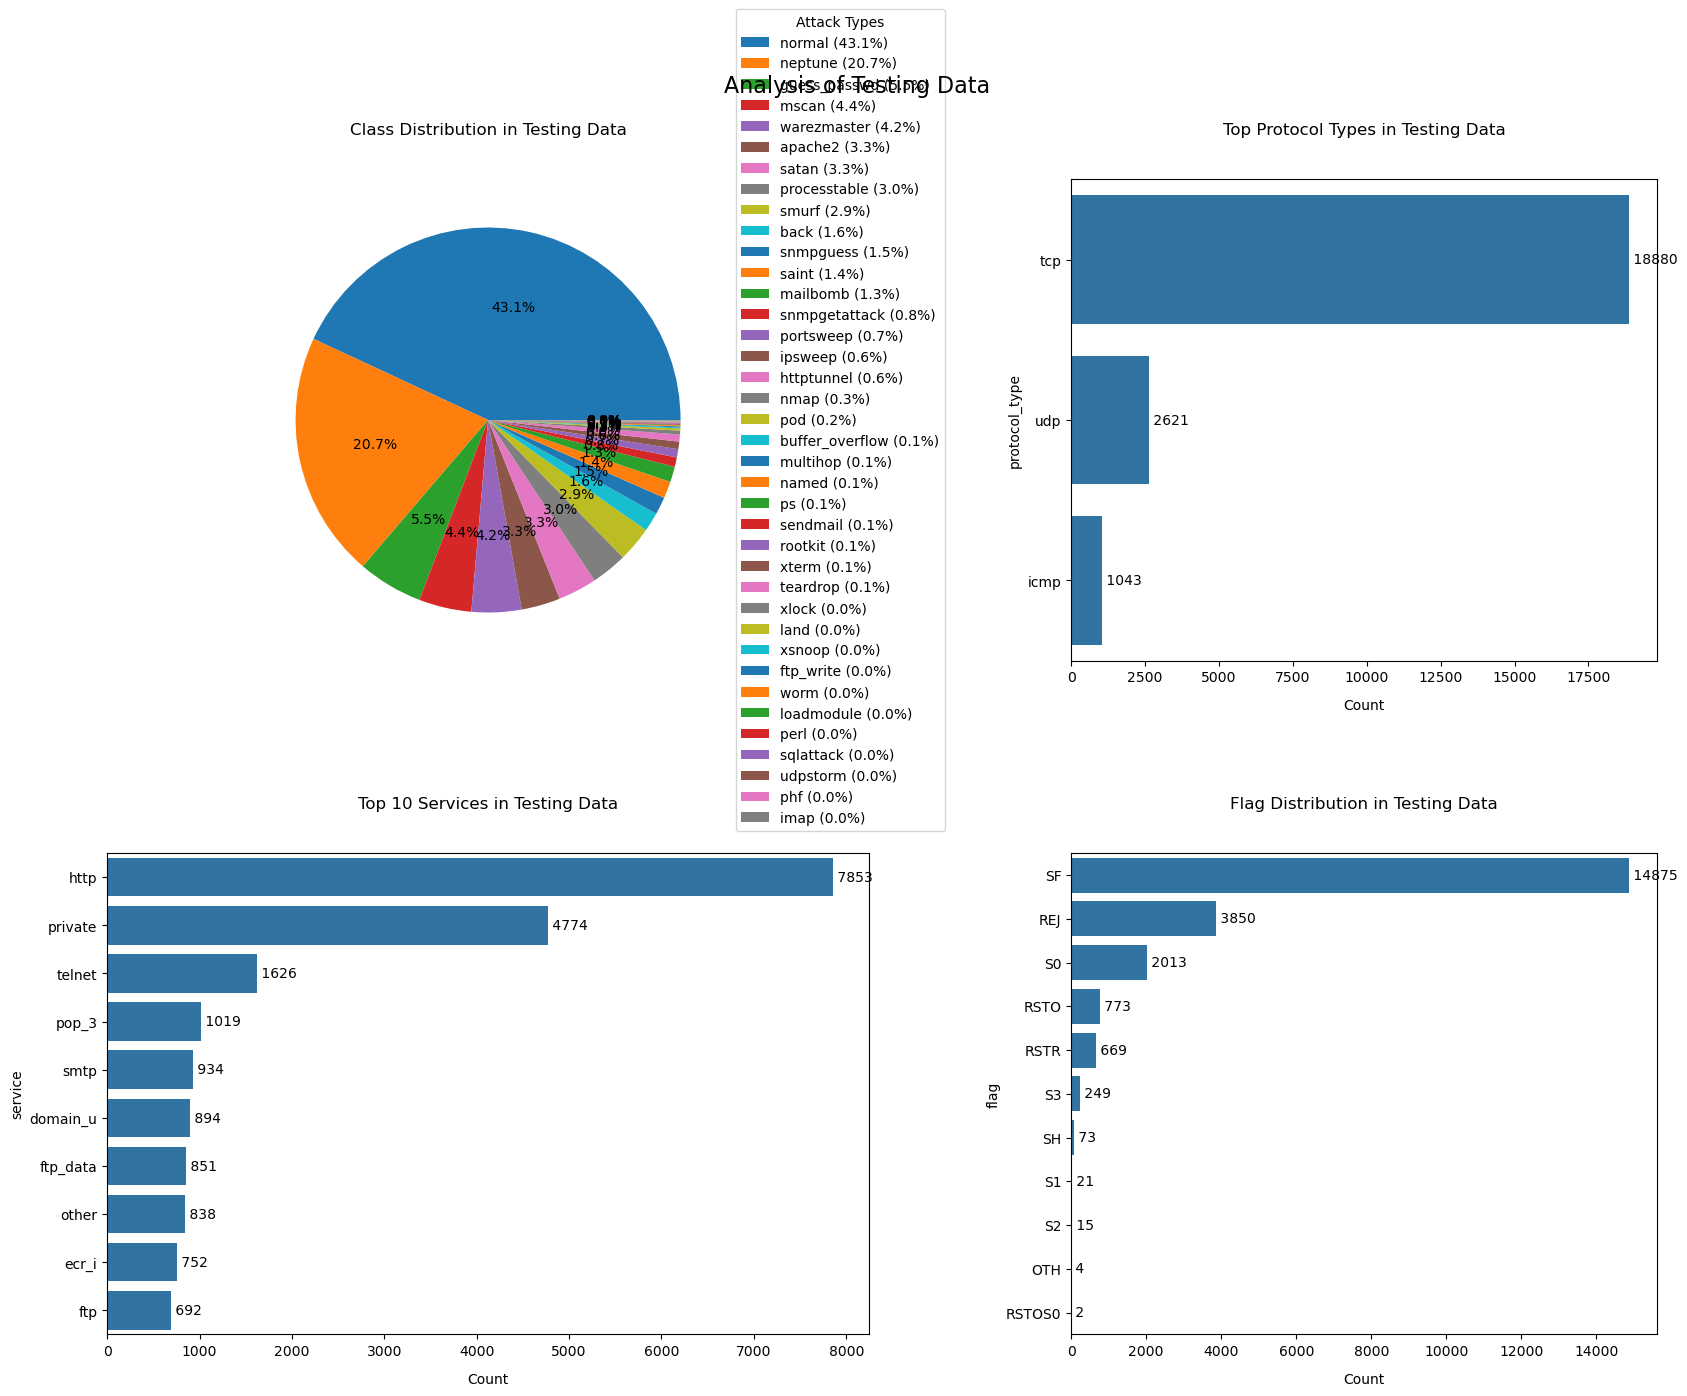

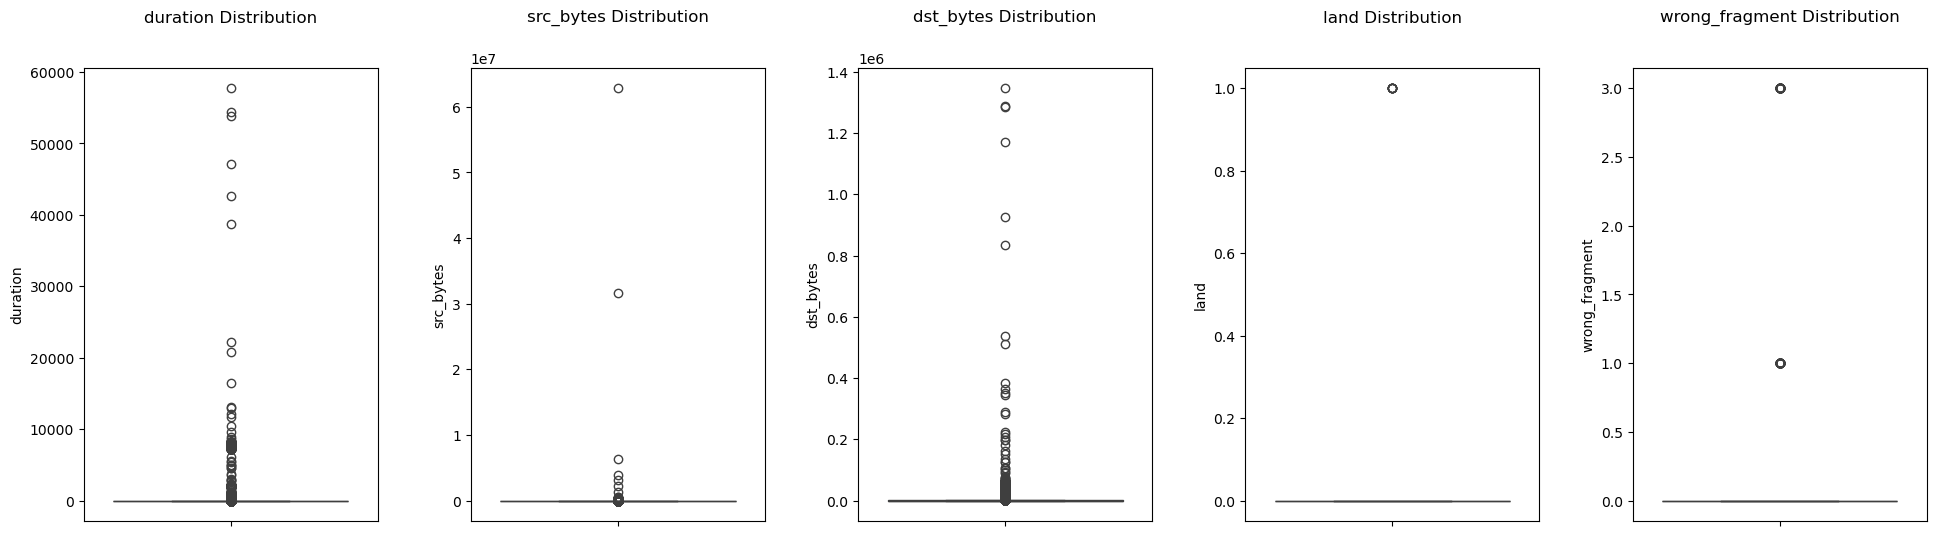

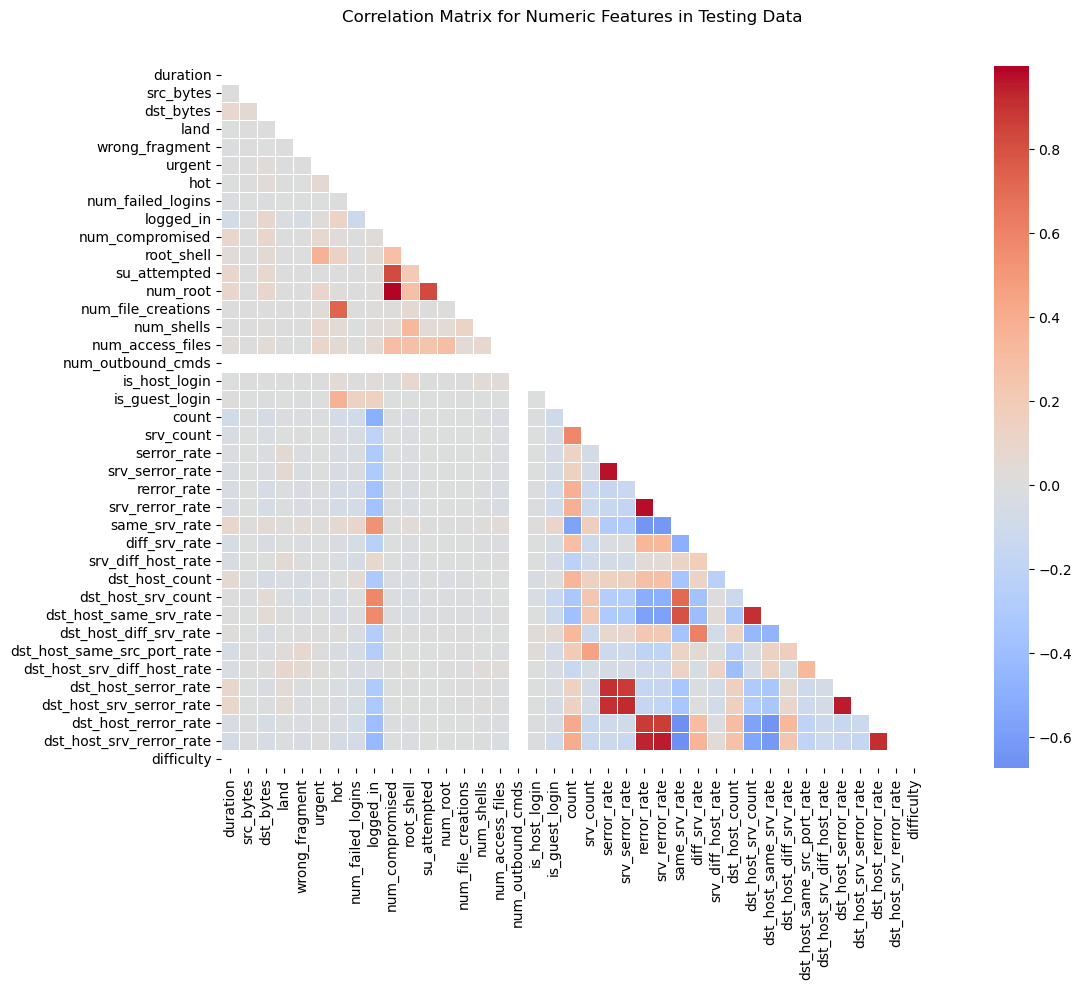

In [76]:
# Phân tích dữ liệu trước khi tiền xử lý
print("Analyzing Training Data:")
analyze_dataset(train_data, "Training Data")
print("\nAnalyzing Testing Data:")
analyze_dataset(test_data, "Testing Data")

In [77]:
# **Tiền xử lý dữ liệu**
x_train, y_train = preprocessing_anomaly(train_data)
x_test, y_test = preprocessing_anomaly(test_data)
x_train.shape

(125973, 41)

In [78]:
# Print shape information
print("\nData Shapes after preprocessing:")
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing data shape: {x_test.shape}")
print(f"Testing labels shape: {y_test.shape}")


Data Shapes after preprocessing:
Training data shape: (125973, 41)
Training labels shape: (125973, 2)
Testing data shape: (22544, 41)
Testing labels shape: (22544, 2)


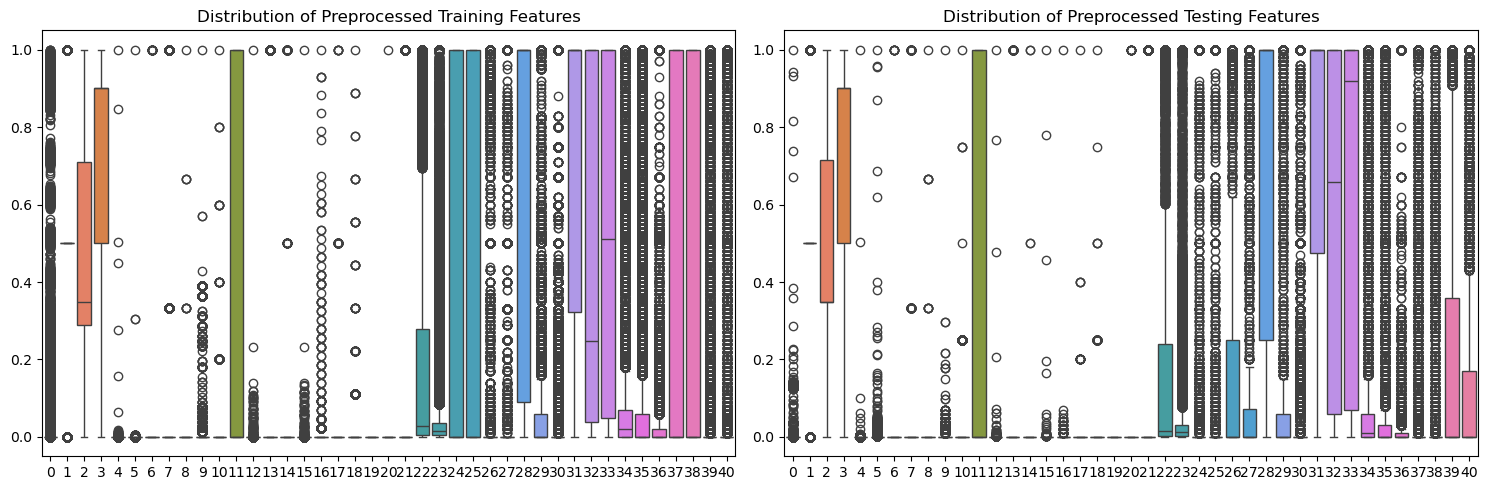

In [79]:
# Visualize preprocessed data distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=pd.DataFrame(x_train))
plt.title('Distribution of Preprocessed Training Features')
plt.subplot(1, 2, 2)
sns.boxplot(data=pd.DataFrame(x_test))
plt.title('Distribution of Preprocessed Testing Features')
plt.tight_layout()
plt.show()

In [80]:
x_train

array([[0.        , 0.5       , 0.28985507, ..., 0.        , 0.05      ,
        0.        ],
       [0.        , 1.        , 0.63768116, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.5       , 0.71014493, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.5       , 0.7826087 , ..., 0.        , 0.01      ,
        0.        ],
       [0.        , 0.5       , 0.43478261, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.5       , 0.28985507, ..., 0.        , 0.        ,
        0.        ]])

In [81]:
# **Chia dữ liệu thành tập huấn luyện và tập kiểm tra**
X_train, X_valid, Y_train, Y_valid = train_test_split(
    x_train, y_train, test_size=0.1, stratify=y_train.argmax(axis=1), random_state=42
)

In [82]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [83]:
with tf.device(f'/{device_name}'):
    model = Sequential()
    model.add(Convolution1D(32, 3, padding="same", activation="relu", input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.5))
    model.add(Convolution1D(64, 3, padding="same", activation="relu"))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation="softmax"))
    
    model.summary()

C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 41, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 41, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 41, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,786 (1.28 MB)

 Trainable params: 334,786 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

In [84]:
# **Biên dịch và huấn luyện mô hình**
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    ModelCheckpoint('model_cnn_kdd_v1.keras', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5),
    CSVLogger('training_cnn_kdd_v1.log')
]

history = model.fit(
    X_train, Y_train, epochs=50, validation_data=(X_valid, Y_valid), batch_size=512, callbacks=callbacks
)


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9214 - loss: 0.2053 - val_accuracy: 0.9678 - val_loss: 0.0882 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9656 - loss: 0.1015 - val_accuracy: 0.9761 - val_loss: 0.0616 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9716 - loss: 0.0799 - val_accuracy: 0.9809 - val_loss: 0.0502 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9738 - loss: 0.0689 - val_accuracy: 0.9851 - val_loss: 0.0430 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9768 - loss: 0.0607 - val_accuracy: 0.9867 - val_loss: 0.0357 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9792 - loss: 0.0537 - val_accuracy: 0.9888 - val_loss: 0.0321 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9802 - loss: 0.

In [87]:
# **Đánh giá mô hình trên tập kiểm tra**
model = load_model('model_cnn_kdd_v1.keras')
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7685 - loss: 1.0569
Test Loss: 1.0930380821228027
Test Accuracy: 0.7633960247039795


In [88]:
# **Dự đoán trên tập kiểm tra**
y_pred = model.predict(x_test)
y_pred_binary = y_pred.argmax(axis=1)
y_test_binary = y_test.argmax(axis=1)

705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [89]:
# **In một vài kết quả dự đoán**
print(f'Predictions: {y_pred_binary[:10]}')
print(f'True Labels: {y_test_binary[:10]}')

Predictions: [1 1 0 1 0 0 0 0 0 0]
True Labels: [1 1 0 1 1 0 0 1 0 1]


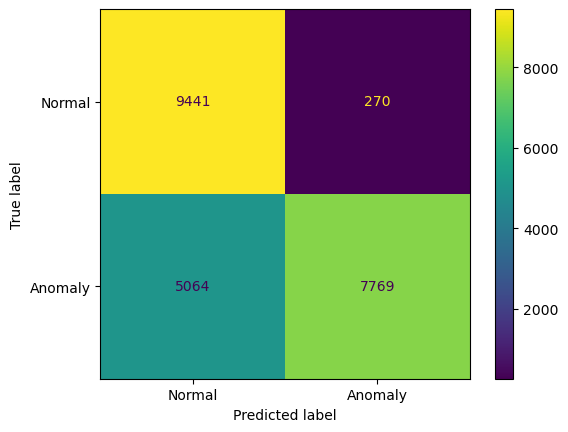

              precision    recall  f1-score   support

      Normal       0.65      0.97      0.78      9711
     Anomaly       0.97      0.61      0.74     12833

    accuracy                           0.76     22544
   macro avg       0.81      0.79      0.76     22544
weighted avg       0.83      0.76      0.76     22544



In [90]:
# **Hiển thị Confusion Matrix và Báo cáo phân loại**
cm = confusion_matrix(y_test_binary, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot()
plt.show()

print(classification_report(y_test_binary, y_pred_binary, target_names=["Normal", "Anomaly"]))

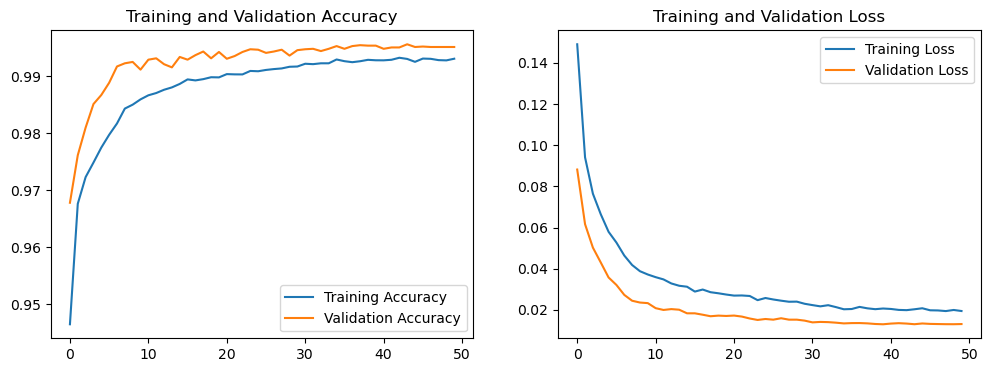

In [91]:
# **Vẽ biểu đồ kết quả huấn luyện**
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
